<p style="font-size:2em;padding-bottom: 0.5em; font-weight: bold;">
E-learning course on <br / >
Advanced Neutron Imaging
</p> 

<p style="font-size:1.25em;padding-bottom: 0.25em;">
    
# Module Number/Introduction to images

</p>

<p style="font-size:1em;">February 25, 2021</p>
<br /><br />
<p style="font-size:1.25em;padding-bottom: 0.25em; text-align: center;">Anders Kaestner</p>


<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Module-Number/Introduction-to-images" data-toc-modified-id="Module-Number/Introduction-to-images-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Module Number/Introduction to images</a></span><ul class="toc-item"><li><span><a href="#Training-objectives" data-toc-modified-id="Training-objectives-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Training objectives</a></span></li></ul></li><li><span><a href="#What-shall-we-do-with-our-images?" data-toc-modified-id="What-shall-we-do-with-our-images?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>What shall we do with our images?</a></span><ul class="toc-item"><li><span><a href="#You-have-data..." data-toc-modified-id="You-have-data...-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>You have data...</a></span><ul class="toc-item"><li><span><a href="#Important-questions" data-toc-modified-id="Important-questions-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Important questions</a></span></li><li><span><a href="#Which-information-do-you-expect-from-the-data" data-toc-modified-id="Which-information-do-you-expect-from-the-data-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Which information do you expect from the data</a></span></li></ul></li><li><span><a href="#Measurements-are-rarely-perfect" data-toc-modified-id="Measurements-are-rarely-perfect-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Measurements are rarely perfect</a></span></li><li><span><a href="#Questions" data-toc-modified-id="Questions-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Questions</a></span></li></ul></li><li><span><a href="#Images" data-toc-modified-id="Images-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Images</a></span><ul class="toc-item"><li><span><a href="#Define-an-image" data-toc-modified-id="Define-an-image-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Define an image</a></span><ul class="toc-item"><li><span><a href="#Different-types-of-images" data-toc-modified-id="Different-types-of-images-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Different types of images</a></span></li></ul></li><li><span><a href="#Pixel-size-and-resolution" data-toc-modified-id="Pixel-size-and-resolution-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Pixel size and resolution</a></span><ul class="toc-item"><li><span><a href="#Edges-at-different-resolutions" data-toc-modified-id="Edges-at-different-resolutions-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Edges at different resolutions</a></span></li></ul></li><li><span><a href="#Image-intensity" data-toc-modified-id="Image-intensity-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Image intensity</a></span><ul class="toc-item"><li><span><a href="#The-histogram" data-toc-modified-id="The-histogram-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>The histogram</a></span></li><li><span><a href="#Visualizing-gray-levels" data-toc-modified-id="Visualizing-gray-levels-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Visualizing gray levels</a></span></li><li><span><a href="#Brightness-and-contrast" data-toc-modified-id="Brightness-and-contrast-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Brightness and contrast</a></span></li></ul></li><li><span><a href="#Pixelwise-operations" data-toc-modified-id="Pixelwise-operations-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Pixelwise operations</a></span></li><li><span><a href="#Questions" data-toc-modified-id="Questions-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Questions</a></span></li></ul></li><li><span><a href="#Noise-in-images" data-toc-modified-id="Noise-in-images-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Noise in images</a></span><ul class="toc-item"><li><span><a href="#Questions" data-toc-modified-id="Questions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Questions</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread
from scipy.ndimage import convolve
from skimage.morphology import disk
from skimage.transform import resize
from itertools import product
import os
from io import StringIO


## Training objectives

- Terminal Training Objectives:
    - Obtain an awareness that numerical methods are needed for the quantitative interpretation of images.
    - Understand the concept of an image processing workflow.

- Enabling training objectives:
    - Understanding that the analysis objectives decide the choice of strategy and tools.
    - Basic definitions of 
        - images
        - gray levels
        - visibility
        - noise


# What shall we do with our images?

## You have data...

Imaging experiments produce large amounts of data

![Experiment data](figures/experimentdata.svg)

### Important questions

What is the purpose of the experiment?

- Qualitative visual analysis using 3D visualization
- Sample characterization
- Determine process parameters
- Count and measure size of features
- etc.



### Which information do you expect from the data


| Intensity  | Geometry |
|:----------|:----------|
| Material composition | Identify features |
| Material transport   | Volume |
| Physical quantities | Shape |

The information you want to quantify affects:
- The choice of processing method
- The experiment strategy 
- The choice of analysis tools


## Measurements are rarely perfect

![](figures/imperfect_imaging_system.svg)

Relevant features versus:
- Resolution
- Sample movement
- Noise
- Inhomogeneous contrast
- Artefacts

## Questions

# Images

## Define an image

### What is an image?

A very abstract definition: 
- __A pairing between spatial information (position)__
- __and some other kind of information (value).__

In most cases this is a 2- or 3-dimensional position (x,y,z coordinates)

### Image sampling
| The world is | The computer needs|
|:---:|:---:|
| Continuous    | Discrete levels |
| No boundaries | Limited extent | 

A real world observation is contious and we need to sample the information in order to bring it into the computer for storage and to perform our analysis. There are different types of sampling involved to get a digital image. 

#### Intensity 
The continous intensity must be sampled into discrete levels represented by a number of bits

#### Locations
The location in the scene must be rasterized into a grid of pixels that contain the image intensity. The size of the pixels determine the greatest spatial frequency that can be respresented in the image. The spatial sampling follows the Nyquist sampling theorem that says that you have to sample by twice as fast the highest frequency in the scene. If you sample too slow you will see aliasing effects that appear as moiree fringes in the image.   

```{figure} figures/grid.pdf
---
scale: 75%
---
The real world is sampled into discrete images with limited extent.
```

<center>
<img src="figures/grid.svg" style="height:400px">
</center>

### Different types of images

## Pixel size and resolution 

It is important to distinguish between pixel size and resolution

### Pixel size
The pixel size is
- The sample pitch between two adjacent pixels
- The smallest area represented in the image

### Resolution 
The resolution is related to the optical system
- It is the effect of the optical transfer function of the acquisition system.
- Should have a greater value than the pixel size.
- Defines the smallest pixel size when you set up your acquistion conditions.


### Demonstrating different pixel sizes
What happens when we represent the same image with less pixels?

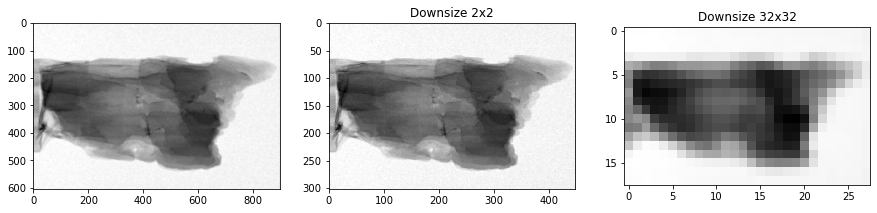

In [36]:
img=np.load('data/wood.npy');
fig,ax = plt.subplots(1,3, figsize=[15,5])
ax[0].imshow(img,cmap='gray'); plt.title('Original')

downsize =  2; 
resized  = resize(img,(img.shape[0] // downsize, img.shape[1] // downsize))
ax[1].imshow(resized, interpolation='None',cmap='gray'); ax[1].set_title('Downsize {0}x{0}'.format(downsize))

downsize = 32; 
resized  = resize(img,(img.shape[0] // downsize, img.shape[1] // downsize))
ax[2].imshow(resized,interpolation='None',cmap='gray'); ax[2].set_title('Downsize {0}x{0}'.format(downsize));

### Edges at different resolutions

<center>
<img src="figures/edges.svg" style="height:400px">
</center>


## Image intensity
What happens when we reduce the number of gray-levels in the image?

The image intensity is determined by the response function of the imaging system. In the case of neutron imaging we are talking about the transmission of the neutron beam through the sample. The transmission follows Beer-Lambert's law
$I(x,y)=I(x,y) e^{-\int_L mu(x) dx}$, this is only a simplified version. More complicated versions including the neutron energy are presented in other parts of this course.

The information captured by the detector is stored in digital form with different gray level dynamics. We are often talking about 8 or 16 bit integer when we store images. This means that each pixel can represent the measured intensity with either 256 or 65565 gray levels respectively. In the example below we demonstrate what happens when only very few gray levels are used.

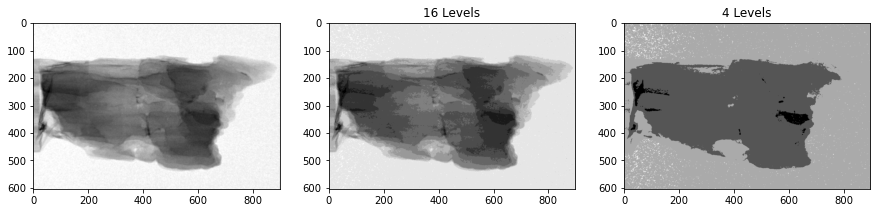

In [35]:
img=np.load('data/wood.npy');
fig,ax = plt.subplots(1,3,figsize=[15,7])
ax[0].imshow(img, cmap='gray'); plt.title('Original')

levels   = 16; 
lvl = np.floor(img*levels)
ax[1].imshow(lvl, cmap='gray'); ax[1].set_title('{0} Levels'.format(levels));

levels   = 4 ; 
lvl = np.floor(img*levels)
ax[2].imshow(lvl, cmap='gray'); ax[2].set_title('{0} Levels'.format(levels));

It is important to use as many gray levels at possible when you expose your images. The image turns patchy when you use too few level as you can see in the example above. This patchiness reduces the precision of your evaluation. The number of gray levels depend on many factors like:

- Exposure time
- Neutron flux
- Conversion efficiency
- Conversion rate of the detector
- Pixel size

So, it is your task to optimize your acquisition to provide well illuminated images by changing these parameters. Some are easier than others to change and contstraint are given by the type of investigation you are doing.

### The histogram

The histogram is a statistical tool to show frequency of each graylevel in the image. 

It is essentially a plot where the you count how many times each gray level appears in the image. For a 16-bit image this would result 65565 points. This is far too detailed therefore it is common to use bins of several gray level to reduce the level of detail in the histogram and also improve the readability. In the example below we use 100 histogram bins which look quite reasonable for this image. Chosing the number of bins depends on the image size too. Your histogram doesn't look very useful if you have too many bins compared to the available number of pixels. You can use the piece of code below to explore what happens when you change the number of bins.

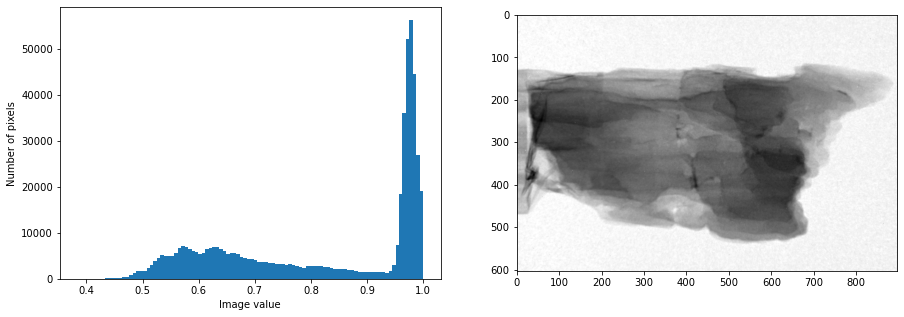

In [34]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

# Compute and show a histogram
ax[0].hist(img.ravel(),bins=100)


ax[0].set_xlabel('Image value'), ax[0].set_ylabel('Number of pixels')
ax[1].imshow(img,cmap='gray');

It can be used for the analysis of the image as it gives you an idea which values are related to different features in the image. The histogram tells you the area covered by a give pixel value and a later section we will see how the histogram can be used to segment the images.

### Details of the histogram
Let's look att different regions in the image and their representation in the histogram.

<center>
<img src="figures/histogram_regions.svg" style="height:400px">
</center>


```{figure} figures/histogram_regions.pdf
---
scale: 75%
---
Regions in the image connected to their position in the histogram.
```


## Visualizing gray levels

The human eye is not able to resolve many intensity levels

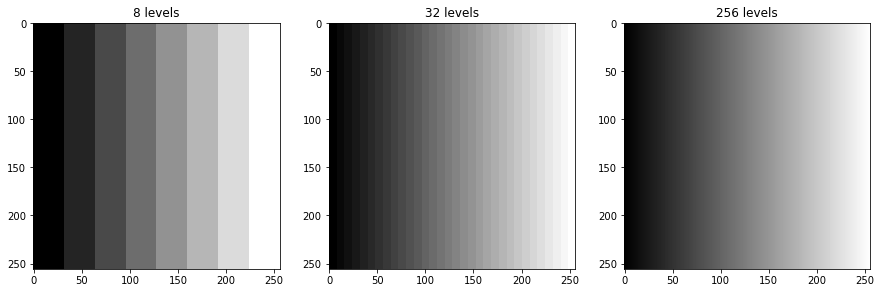

In [42]:
xlin = np.linspace(0,255, 256)
xx, yy = np.meshgrid(xlin, xlin)

fig, ax = plt.subplots(1,3, figsize = (15, 5))
n=32; ax[0].imshow(np.floor(xx/n), interpolation='None', cmap = 'gray');  ax[0].set_title('{0} levels'.format(256//n))
n=8;  ax[1].imshow(np.floor(xx/n), interpolation='None', cmap = 'gray');  ax[1].set_title('{0} levels'.format(256//n))
n=1;  ax[2].imshow(np.floor(xx/n), interpolation='None', cmap = 'gray');  ax[2].set_title('{0} levels'.format(256//n));

### Using pseudo colormaps

The image intensity is mostly only represented by a scalar by a gray level. Which is makes it hard to see subtle changes in intensity. Colormaps can help here.

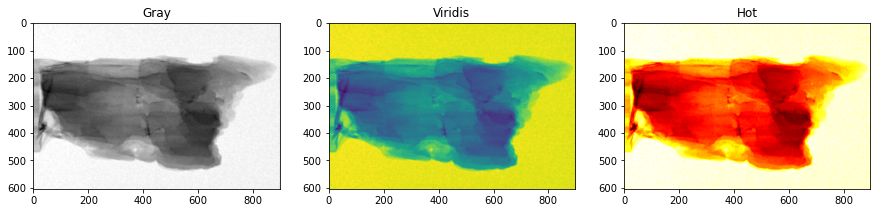

In [39]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(img,cmap='gray');    ax[0].set_title('Gray')
ax[1].imshow(img,cmap='viridis'); ax[1].set_title('Viridis')
ax[2].imshow(img,cmap='hot');     ax[2].set_title('Hot');

### Brightness
With image brightness, you can focus on narrow gray level intervals to better visually resolve local details.

<center>
<img src="figures/histogram_brightness.svg" style="height:400px">
</center>

```{figure} figures/histogram_brightness.pdf
---
scale: 75%
---
Narrow intensity intervals to highlight low (left) and high (right) graylevel regions.
```


### Contrast

Contrast controls the width of the intensity interval to use.

<center>
<img src="figures/histogram_contrast.svg" style="height:400px">
</center>

Contrast control is often used to define which gray levels to include when you save image to file. The image is usually represented in floating point data format after some calculations and you have to limit the interval to resolve the relevant information with many gray levels and reject outliers when you convert to 8- or 16-bit integers. 

The example shows a narrow interval that mostly is useful to highlight features with small difference in contrast. The example with wider interval would is set to reject the background while most of the sample is visible. This setting may be useful for presentationations and publication where you want to boost the visibility, but is not recommended if you want to use the image in further calculations. In the latter case it is important to keep as many gray levels as possible, i.e. also include the noise flucuations in the background.

```{figure} figures/histogram_contrast.pdf
---
scale: 75%
---
Different image contrasts. Narrow interval to the left and wide interval to the right.
```


## Pixelwise operations

## Questions

# Noise in images

## Questions

# Summary 
